<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Required Libraries and Modules</h2>
</div>

**Note: This notebook is run in Paperspace platform**

In [1]:
!pip install transformers
!pip install imblearn
!pip install torch

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,  classification_report
from imblearn.under_sampling import RandomUnderSampler

import torch
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

/tmp/ipykernel_587/1605486461.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Import Clean Text Data</h2>
</div>

In [3]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'
    
    
###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('/datasets/data/bully_data_clean_with_stopword_short.csv', encoding='utf8')
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['role','text_check']]

def convert_role_label(x):
    if x == "None":
        return int(0)
    elif x == "Harasser":
        return int(1)
    elif x == "Victim":
        return int(2)
    elif x == "Bystander_defender":
        return int(3)
    elif x == "Bystander_assistant":
        return int(1)

bully_data_cleaned['label'] = bully_data_cleaned['role'].progress_apply(lambda x: convert_role_label(x)).astype(int)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/112247 [00:00<?, ?it/s]

In [4]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112247 entries, 0 to 112246
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   role    112247 non-null  object
 1   text    112247 non-null  object
 2   label   112247 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [5]:
bully_data_cleaned['label'].value_counts()

0    106872
1      3596
2      1354
3       425
Name: label, dtype: int64

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define pretrained tokenizer and model</h2>
</div>

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Define pretrained tokenizer and model

model_name = "google/electra-small-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
set_seed(1127)
model= AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                            num_labels=4,  
                                                            ignore_mismatched_sizes=True)
# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained(model_name, 
#                                                             num_labels=4,  
#                                                             ignore_mismatched_sizes=True,
#                                                             output_attentions = False, # Whether the model returns attentions weights.
#                                                             output_hidden_states = False,
#                                                             return_dict=True )

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Preprocess data</h2>
</div>

In [7]:
##############################
# Data: Text Input and Label #
##############################
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])


########################
# Create torch dataset #
########################
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


#############################
# Define Trainer parameters #
#############################
average_method = 'macro'
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average=average_method)
    precision = precision_score(y_true=labels, y_pred=pred, average=average_method)
    f1 = f1_score(y_true=labels, y_pred=pred, average=average_method)
    
    recall0 = recall_score(y_true=labels, y_pred=pred, average=None)[0]
    precision0 = precision_score(y_true=labels, y_pred=pred, average=None)[0]
    f10 = f1_score(y_true=labels, y_pred=pred, average=None)[0]
    
    recall1 = recall_score(y_true=labels, y_pred=pred, average=None)[1]
    precision1 = precision_score(y_true=labels, y_pred=pred, average=None)[1]
    f11 = f1_score(y_true=labels, y_pred=pred, average=None)[1]
    
    recall2 = recall_score(y_true=labels, y_pred=pred, average=None)[2]
    precision2 = precision_score(y_true=labels, y_pred=pred, average=None)[2]
    f12 = f1_score(y_true=labels, y_pred=pred, average=None)[2]
    
    recall3 = recall_score(y_true=labels, y_pred=pred, average=None)[3]
    precision3 = precision_score(y_true=labels, y_pred=pred, average=None)[3]
    f13 = f1_score(y_true=labels, y_pred=pred, average=None)[3]

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1,
           "precision_nonbully": precision0, "recall_nonbully": recall0, "f1_nonbully": f10,
           "precision_harasser": precision1, "recall_harasser": recall1, "f1_harasser": f11,
           "precision_victim": precision2, "recall_victim": recall2, "f1_victim": f12,
           "precision_bydefender": precision3, "recall_bydefender": recall3, "f1_bydefender": f13}



#########################
# Plot Confusion Matrix #
#########################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


########################
# Run cross-validation #
########################
def run_cross_validation(model_name='RoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=False):
  
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)
    # kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)

        # Split to train and test set for each fold
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]


        # Obtain undersampled index 
        X_temp = bully_data_cleaned["text"].values
        y_temp = bully_data_cleaned["label"].values

        X_temp_train = X_temp[train] 
        y_temp_train = y_temp[train] 

        resample = RandomUnderSampler(random_state=1127,sampling_strategy={0:33363})
        X_temp_resampled, y_temp_resampled = resample.fit_resample(X_temp_train.reshape(-1,1), y_temp_train)

        resample_index = list(resample.sample_indices_)
        print(len(resample_index))


        # Undersample train set
        X_train_resample = [X_train[i] for i in resample_index]
        y_train_resample = [y_train[i] for i in resample_index]


        # Checking proportion
        print(Counter(y))
        print(Counter(y_train))
        print(Counter(y_temp_resampled))
        print(Counter(y_train_resample))

        
        # Tokenize
        X_train_tokenized = tokenizer(X_train_resample, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)


        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train_resample)
        val_dataset = Dataset(X_val_tokenized, y_val)  

        # Fine Tune Transformer
        # Define Trainer
        args = TrainingArguments(
                output_dir="content/drive/MyDrive/output_" + model_name + "/fold"+str(n_fold),
                evaluation_strategy="epoch",
                save_strategy="epoch",
                #eval_steps=500,
                #per_device_train_batch_size=1,
                #per_device_eval_batch_size=1,
                num_train_epochs=epoch, #1 was okay
                seed=1127,
                load_best_model_at_end=True,
            )

        trainer = Trainer(
                  # model_init=model_init,
                  model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  compute_metrics=compute_metrics,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
              )

        trainer.train(resume_from_checkpoint=checkpoint)
        print("Complete for fold", n_fold)
        n_fold= n_fold + 1


#####################
# Run Hold Out Test #
#####################

# Obtain undersample index 
X_temp = bully_data_cleaned["text"].values
y_temp = bully_data_cleaned["label"].values

X_temp_train, X_temp_val, y_temp_train, y_temp_val =  train_test_split(X_temp,y_temp, test_size=0.1, random_state=1127, stratify=y_temp) 
resample = RandomUnderSampler(random_state=1127,sampling_strategy={0:33363})
X_temp_resampled, y_temp_resampled = resample.fit_resample(X_temp_train.reshape(-1,1), y_temp_train)
resample_index = list(resample.sample_indices_)

# Split to train and test set
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Undersample train set
X_train_resample = [X_train[i] for i in resample_index]
y_train_resample = [y_train[i] for i in resample_index]

# Checking proportion
print(Counter(y_temp_resampled))
print(Counter(y_train_resample))

# Split to train and validate set
# X_train_resample, X_val, y_train_resample, y_val = train_test_split(X_train_resample, y_train_resample, test_size=0.1, stratify=y_train_resample, random_state=1127)

X_train_tokenized = tokenizer(X_train_resample, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train_resample)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='Electra',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):
  
    print("Developing Model with Hold Out Splits for: " + model_name)
    
    # Fine Tune Transformer
    # Define Trainer
    
    args = TrainingArguments(
    output_dir="content/drive/MyDrive/output_" + model_name + "/holdout",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    #eval_steps=500,
    #per_device_train_batch_size=1,
    #per_device_eval_batch_size=1,
    num_train_epochs=epoch, #1 was okay
    seed=1127,
    load_best_model_at_end=True,
    )

    trainer = Trainer(
    #model_init=model_init,
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out validate set")

Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


In [8]:
###########################
# Predict (Hold Out Test) #
###########################

from sklearn.metrics import confusion_matrix

def compute_metrics_holdout(model_name='Electra',
                            model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-3820', 
                            average_method='macro',
                            X_test=X_test):
  
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision = precision_score(y_test, y_pred, average=average_method)
    recall = recall_score(y_test, y_pred, average=average_method)
    f1 = f1_score(y_test, y_pred, average=average_method)

    precision0 = precision_score(y_test, y_pred, average=None)[0]
    recall0 = recall_score(y_test, y_pred, average=None)[0]
    f10 = f1_score(y_test, y_pred, average=None)[0]

    precision1 = precision_score(y_test, y_pred, average=None)[1]
    recall1 = recall_score(y_test, y_pred, average=None)[1]
    f11 = f1_score(y_test, y_pred, average=None)[1]

    precision2 = precision_score(y_test, y_pred, average=None)[2]
    recall2 = recall_score(y_test, y_pred, average=None)[2]
    f12 = f1_score(y_test, y_pred, average=None)[2]

    precision3 = precision_score(y_test, y_pred, average=None)[3]
    recall3 = recall_score(y_test, y_pred, average=None)[3]
    f13 = f1_score(y_test, y_pred, average=None)[3]


    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Macro Metrics:")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-measure: ", f1)
    print()
    print("Label 0: Non-bully")
    print("Precision: ", precision0)
    print("Recall: ", recall0)
    print("F-measure: ", f10)
    print()
    print("Label 1: Harasser")
    print("Precision: ", precision1)
    print("Recall: ", recall1)
    print("F-measure: ", f11)
    print()
    print("Label 2: Victim")
    print("Precision: ", precision2)
    print("Recall: ", recall2)
    print("F-measure: ", f12)
    print()
    print("Label 3: Bystander-defender")
    print("Precision: ", precision3)
    print("Recall: ", recall3)
    print("F-measure: ", f13)
    print()

    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-bully', 'Harasser','Victim','Bystander-defender']
    labels = ['True Non-bully','','','',
            '','True Harasser','','',
            '','','True Victim','',
            '','','','True Bystander-defender']
    make_confusion_matrix(conf_mat, 
                        group_names=labels,
                        categories=categories, 
                        figsize=(12,8), 
                        cbar=True, 
                        title='Fine Tuned' + model_name + ' for Participant Roles Identification', 
                        cmap='YlGnBu', 
                        sum_stats=False)


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Cross Validation (K = 5)</h2>
</div>

In [9]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.315200,0.166005,0.948775,0.442442,0.507217,0.455687,0.981321,0.973332,0.977310,0.439922,0.630556,0.518265,0.133333,0.029630,0.048485,0.215190,0.395349,0.278689
2,0.299800,0.181251,0.944499,0.457198,0.461244,0.432798,0.984283,0.966876,0.975502,0.422559,0.697222,0.526205,0.121951,0.111111,0.116279,0.300000,0.069767,0.113208
3,0.232000,0.162128,0.954031,0.497542,0.491112,0.482486,0.981856,0.977262,0.979554,0.488048,0.680556,0.568445,0.175439,0.074074,0.104167,0.344828,0.232558,0.277778
4,0.215200,0.195407,0.947528,0.505378,0.549076,0.521411,0.985060,0.968654,0.976788,0.453532,0.677778,0.543430,0.172662,0.177778,0.175182,0.410256,0.372093,0.390244


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold1/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold1/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold1/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-14325/config.json
Model weights saved in content/drive/MyDrive/

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.295600,0.167429,0.942094,0.486251,0.635428,0.539619,0.989385,0.959390,0.974157,0.421824,0.719444,0.531828,0.228916,0.281481,0.252492,0.304878,0.581395,0.400000
2,0.230100,0.159635,0.957951,0.588482,0.579921,0.573501,0.985477,0.977824,0.981635,0.509804,0.722222,0.597701,0.315789,0.177778,0.227488,0.542857,0.441860,0.487179
3,0.179700,0.177914,0.954922,0.552854,0.632889,0.581026,0.987646,0.972490,0.980009,0.496283,0.741667,0.594655,0.346535,0.259259,0.296610,0.380952,0.558140,0.452830
4,0.176400,0.193594,0.955813,0.589518,0.651106,0.614002,0.988394,0.972209,0.980235,0.505576,0.755556,0.605791,0.330769,0.318519,0.324528,0.533333,0.558140,0.545455


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold2/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold2/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold2/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-14325/config.json
Model weights saved in content/drive/MyDrive/

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.261300,0.132129,0.961158,0.623687,0.627028,0.619992,0.987921,0.979601,0.983744,0.546584,0.733333,0.626335,0.293578,0.237037,0.262295,0.666667,0.558140,0.607595
2,0.221000,0.150609,0.959465,0.595493,0.640125,0.608283,0.988724,0.976326,0.982486,0.524254,0.780556,0.627232,0.337079,0.222222,0.267857,0.531915,0.581395,0.555556
3,0.164600,0.158270,0.962227,0.595302,0.657049,0.622096,0.987561,0.980631,0.984084,0.593533,0.713889,0.648172,0.282258,0.259259,0.270270,0.517857,0.674419,0.585859
4,0.133900,0.183346,0.959376,0.590048,0.652282,0.617347,0.988915,0.976701,0.982770,0.553015,0.738889,0.632580,0.276596,0.288889,0.282609,0.541667,0.604651,0.571429


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold3/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold3/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold3/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-14325/config.json
Model weights saved in content/drive/MyDrive/

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.235200,0.129389,0.963653,0.653538,0.678778,0.657998,0.991552,0.977449,0.984450,0.555140,0.825000,0.663687,0.428571,0.377778,0.401575,0.638889,0.534884,0.582278
2,0.199500,0.142258,0.959020,0.589111,0.714676,0.637985,0.992081,0.972958,0.982426,0.525735,0.794444,0.632743,0.375940,0.370370,0.373134,0.462687,0.720930,0.563636
3,0.180500,0.154404,0.962762,0.606556,0.698652,0.645821,0.991830,0.976888,0.984302,0.572854,0.797222,0.666667,0.370629,0.392593,0.381295,0.490909,0.627907,0.551020
4,0.142500,0.166893,0.961514,0.622503,0.698755,0.653777,0.991906,0.974736,0.983246,0.547486,0.816667,0.655518,0.407143,0.422222,0.414545,0.543478,0.581395,0.561798


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold4/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold4/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold4/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-14325/config.json
Model weights saved in content/drive/MyDrive/

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.236000,0.107106,0.965969,0.628043,0.739851,0.671262,0.991852,0.979601,0.985689,0.603696,0.816667,0.694215,0.379310,0.325926,0.350598,0.537313,0.837209,0.654545
2,0.204500,0.143349,0.962049,0.687861,0.681293,0.664859,0.993513,0.974549,0.983940,0.532095,0.875000,0.661765,0.373984,0.340741,0.356589,0.851852,0.534884,0.657143
3,0.150600,0.146164,0.965612,0.649944,0.721357,0.678497,0.992124,0.978385,0.985207,0.590385,0.852778,0.697727,0.384615,0.333333,0.357143,0.632653,0.720930,0.673913
4,0.123900,0.157405,0.967038,0.652355,0.736716,0.689377,0.991389,0.980350,0.985839,0.630108,0.813889,0.710303,0.376812,0.385185,0.380952,0.611111,0.767442,0.680412


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold5/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold5/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold5/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-14325/config.json
Model weights saved in content/drive/MyDrive/

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold1/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.226800,0.183163,0.950557,0.533779,0.539255,0.528559,0.984091,0.972396,0.978209,0.480167,0.638889,0.548272,0.226415,0.266667,0.244898,0.444444,0.279070,0.342857
6,0.181300,0.215123,0.946548,0.498362,0.579294,0.529694,0.984752,0.966876,0.975732,0.442029,0.677778,0.535088,0.233333,0.207407,0.219608,0.333333,0.465116,0.388350
7,0.170500,0.226283,0.949220,0.517173,0.589677,0.547970,0.983964,0.970338,0.977104,0.469136,0.633333,0.539007,0.253521,0.266667,0.259928,0.362069,0.488372,0.415842


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold1/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold1/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold1/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-33425/config.json
Model weights saved in content/drive/My

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold2/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.190800,0.209419,0.950735,0.615545,0.620514,0.596557,0.989470,0.967156,0.978186,0.483126,0.755556,0.589382,0.239583,0.340741,0.281346,0.750000,0.418605,0.537313
6,0.147300,0.216284,0.953853,0.554308,0.604926,0.574608,0.987457,0.972396,0.979869,0.530398,0.702778,0.604540,0.237838,0.325926,0.275000,0.461538,0.418605,0.439024
7,0.132300,0.226952,0.956526,0.581745,0.629714,0.600931,0.987664,0.973894,0.980730,0.524462,0.744444,0.615385,0.291045,0.288889,0.289963,0.523810,0.511628,0.517647


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold2/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold2/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold2/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-33425/config.json
Model weights saved in content/drive/My

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold3/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.143500,0.184056,0.960535,0.595875,0.660504,0.625090,0.988183,0.978104,0.983118,0.605201,0.711111,0.653895,0.270115,0.348148,0.304207,0.520000,0.604651,0.559140


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold3/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-23875/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


Loading model from content/drive/MyDrive/output_Electra/fold1/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 7
  Continuing training from global step 33425
  Will skip the first 7 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on dat

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.169200,0.250680,0.946548,0.508796,0.581116,0.539447,0.984753,0.966969,0.975780,0.465209,0.650000,0.542294,0.217877,0.288889,0.248408,0.367347,0.418605,0.391304


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold1/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold1/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_Electra/fold1/checkpoint-14325 (score: 0.1621275246143341).
1it [09:34, 574.37s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold2/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.130600,0.236152,0.955100,0.558696,0.622263,0.586130,0.987473,0.973613,0.980494,0.518145,0.713889,0.600467,0.250000,0.266667,0.258065,0.479167,0.534884,0.505495


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold2/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold2/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_Electra/fold2/checkpoint-9550 (score: 0.1596347987651825).
2it [19:06, 572.93s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold3/checkpoint-23875).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
6,0.150800,0.198749,0.960713,0.587982,0.655921,0.618241,0.988092,0.978291,0.983167,0.581655,0.722222,0.644362,0.300699,0.318519,0.309353,0.481481,0.604651,0.536082
7,0.114900,0.217953,0.957416,0.585450,0.660658,0.618591,0.988896,0.975016,0.981907,0.545455,0.700000,0.613139,0.276836,0.362963,0.314103,0.530612,0.604651,0.565217
8,0.084700,0.231821,0.959109,0.586246,0.667933,0.622177,0.989097,0.976233,0.982623,0.554604,0.719444,0.626360,0.301282,0.348148,0.323024,0.500000,0.627907,0.556701


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold3/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold3/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-33425/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-33425/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold3/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_Electra/fold3/checkpoint-38200/config.json
Model weights saved in content/drive/My

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold4/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.143600,0.159402,0.962940,0.625676,0.651763,0.633173,0.990343,0.978759,0.984517,0.558416,0.783333,0.652023,0.375000,0.333333,0.352941,0.578947,0.511628,0.543210
6,0.136800,0.195283,0.959020,0.596164,0.684931,0.632798,0.991609,0.973145,0.982290,0.529412,0.800000,0.637168,0.363636,0.385185,0.374101,0.500000,0.581395,0.537634
7,0.109300,0.198935,0.963029,0.623976,0.696525,0.655471,0.990050,0.977636,0.983804,0.579381,0.780556,0.665089,0.397059,0.400000,0.398524,0.529412,0.627907,0.574468


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold4/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold4/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold4/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-33425/config.json
Model weights saved in content/drive/My

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold5/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.139200,0.156019,0.963474,0.631491,0.738273,0.677554,0.991827,0.976607,0.984158,0.622807,0.788889,0.696078,0.326425,0.466667,0.384146,0.584906,0.720930,0.645833
6,0.110300,0.175497,0.964276,0.645289,0.717764,0.677199,0.991181,0.978011,0.984552,0.598344,0.802778,0.685647,0.353333,0.392593,0.371930,0.638298,0.697674,0.666667
7,0.102700,0.189856,0.965523,0.646254,0.726133,0.682166,0.991103,0.979789,0.985413,0.620309,0.780556,0.691267,0.346154,0.400000,0.371134,0.627451,0.744186,0.680851


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold5/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold5/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold5/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-33425/config.json
Model weights saved in content/drive/My

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


Loading model from content/drive/MyDrive/output_Electra/fold1/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 38200
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on dat

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_Electra/fold1/checkpoint-14325 (score: 0.1621275246143341).


Epoch,Training Loss,Validation Loss


1it [00:19, 19.71s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold2/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_Electra/fold2/checkpoint-9550 (score: 0.1596347987651825).


Epoch,Training Loss,Validation Loss


2it [00:33, 16.08s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold3/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_Electra/fold3/checkpoint-4775 (score: 0.1321289986371994).


Epoch,Training Loss,Validation Loss


3it [00:47, 15.06s/it]

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold4/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.081500,0.213976,0.960891,0.605447,0.694923,0.644178,0.990408,0.975859,0.983080,0.558045,0.761111,0.643948,0.373333,0.414815,0.392982,0.500000,0.627907,0.556701


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold4/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold4/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_Electra/fold4/checkpoint-4775 (score: 0.12938901782035828).
4it [18:48, 436.17s/it]

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/fold5/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.083600,0.205407,0.964187,0.626394,0.720176,0.667447,0.991277,0.978291,0.984741,0.604255,0.788889,0.684337,0.346405,0.392593,0.368056,0.563636,0.720930,0.632653


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/fold5/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_Electra/fold5/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_Electra/fold5/checkpoint-4775 (score: 0.10710639506578445).
5it [36:47, 441.53s/it]

Complete for fold 5


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Hold Out Split)</h2>
</div>

In [10]:
run_hold_out_split(model_name='Electra',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200


Developing Model with Hold Out Splits for: Electra


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.207600,0.153210,0.966236,0.621817,0.704137,0.644382,0.989709,0.980911,0.985291,0.622560,0.797222,0.699147,0.500000,0.340741,0.405286,0.375000,0.697674,0.487805
2,0.188100,0.163819,0.959287,0.584026,0.710238,0.636371,0.991981,0.972303,0.982043,0.587525,0.811111,0.681447,0.298969,0.429630,0.352584,0.457627,0.627907,0.529412
3,0.157700,0.171419,0.963831,0.607529,0.656631,0.628148,0.988854,0.979601,0.984206,0.602128,0.786111,0.681928,0.369748,0.325926,0.346457,0.469388,0.534884,0.500000
4,0.135400,0.189250,0.962940,0.600995,0.683582,0.631889,0.989209,0.977824,0.983483,0.589212,0.788889,0.674584,0.437500,0.362963,0.396761,0.388060,0.604651,0.472727
5,0.101500,0.200231,0.962316,0.595895,0.695659,0.638721,0.989764,0.977169,0.983426,0.623557,0.750000,0.680958,0.353591,0.474074,0.405063,0.416667,0.581395,0.485437
6,0.072500,0.230109,0.960267,0.592517,0.711464,0.642563,0.991330,0.973613,0.982392,0.588358,0.786111,0.673008,0.342105,0.481481,0.400000,0.448276,0.604651,0.514851


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/holdout/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/holdout/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/holdout/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-14325/config.json
Model weights saved in conten

Complete for hold-out validate set


In [18]:
run_hold_out_split(model_name='Electra',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_Electra/holdout/checkpoint-28650).


Developing Model with Hold Out Splits for: Electra


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 6
  Continuing training from global step 28650
  Will skip the first 6 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
7,0.083700,0.213731,0.964009,0.616178,0.695501,0.651677,0.989964,0.978385,0.984140,0.623608,0.777778,0.692213,0.370370,0.444444,0.404040,0.480769,0.581395,0.526316
8,0.082100,0.238979,0.961514,0.593721,0.700700,0.639487,0.990872,0.975110,0.982928,0.598326,0.794444,0.682578,0.354651,0.451852,0.397394,0.431034,0.581395,0.495050


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/holdout/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-33425/config.json
Model weights saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-33425/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_Electra/holdout/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_Electra/holdout/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_Electra/holdout/checkpoint-4775 (score: 0.15321004390716553).


Complete for hold-out validate set


### Test Split Cross Validation

#### Epoch 1

loading configuration file content/drive/MyDrive/output_Electra/holdout/checkpoint-4775/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive/output_Electra/holdout/checkpoint-4775",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_d

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.62      0.80      0.70       360
           2       0.50      0.34      0.41       135
           3       0.38      0.70      0.49        43

    accuracy                           0.97     11225
   macro avg       0.62      0.70      0.64     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6218172168574818
Recall:  0.7041371923087183
F-measure:  0.6443823162646698

Label 0: Non-bully
Precision:  0.9897092145015106
Recall:  0.9809113876672593
F-measure:  0.9852906621551766

Label 1: Harasser
Precision:  0.6225596529284165
Recall:  0.7972222222222223
F-measure:  0.6991473812423874

Label 2: Victim
Precision:  0.5
Recall:  0.34074074074074073
F-measure:  0.4052863436123348

Label 3: Bystander-defender
Precision:  0.375
Recall:  0.6976744186046512
F-measure:  0.4878048780487806



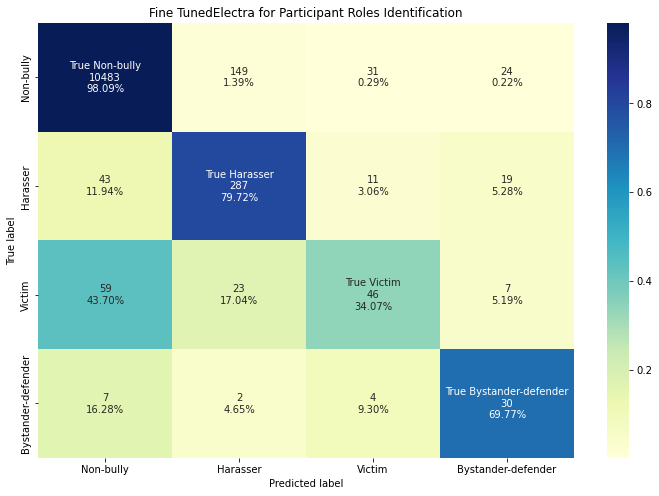

In [11]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-4775', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 2

loading configuration file content/drive/MyDrive/output_Electra/holdout/checkpoint-9550/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive/output_Electra/holdout/checkpoint-9550",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_d

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10687
           1       0.59      0.81      0.68       360
           2       0.30      0.43      0.35       135
           3       0.46      0.63      0.53        43

    accuracy                           0.96     11225
   macro avg       0.58      0.71      0.64     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.5840255621589224
Recall:  0.7102376288191592
F-measure:  0.6363713860709305

Label 0: Non-bully
Precision:  0.9919809069212411
Recall:  0.9723027977917096
F-measure:  0.9820432851337303

Label 1: Harasser
Precision:  0.5875251509054326
Recall:  0.8111111111111111
F-measure:  0.6814469078179696

Label 2: Victim
Precision:  0.29896907216494845
Recall:  0.42962962962962964
F-measure:  0.3525835866261398

Label 3: Bystander-defender
Precision:  0.4576271186440678
Recall:  0.627906976744186
F-measure:  0.5294117

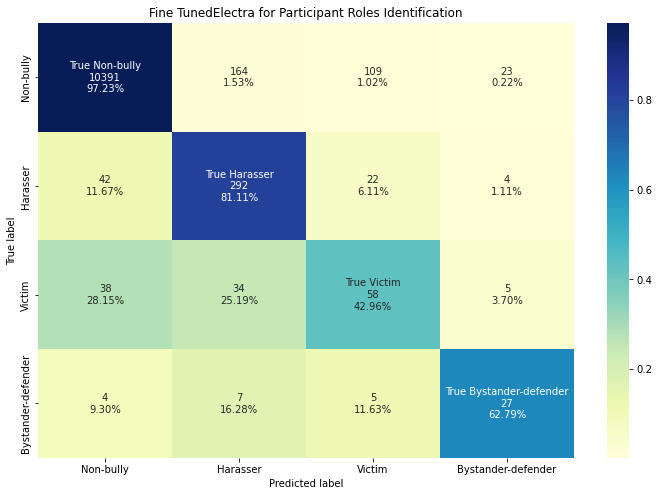

In [12]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-9550', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 3

loading configuration file content/drive/MyDrive/output_Electra/holdout/checkpoint-14325/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive/output_Electra/holdout/checkpoint-14325",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.60      0.79      0.68       360
           2       0.37      0.33      0.35       135
           3       0.47      0.53      0.50        43

    accuracy                           0.96     11225
   macro avg       0.61      0.66      0.63     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.6075293922637093
Recall:  0.656630535706845
F-measure:  0.6281476192244206

Label 0: Non-bully
Precision:  0.9888542552186644
Recall:  0.9796013848601104
F-measure:  0.9842060731409231

Label 1: Harasser
Precision:  0.6021276595744681
Recall:  0.7861111111111111
F-measure:  0.6819277108433736

Label 2: Victim
Precision:  0.3697478991596639
Recall:  0.32592592592592595
F-measure:  0.3464566929133859

Label 3: Bystander-defender
Precision:  0.46938775510204084
Recall:  0.5348837209302325
F-measure:  0.5



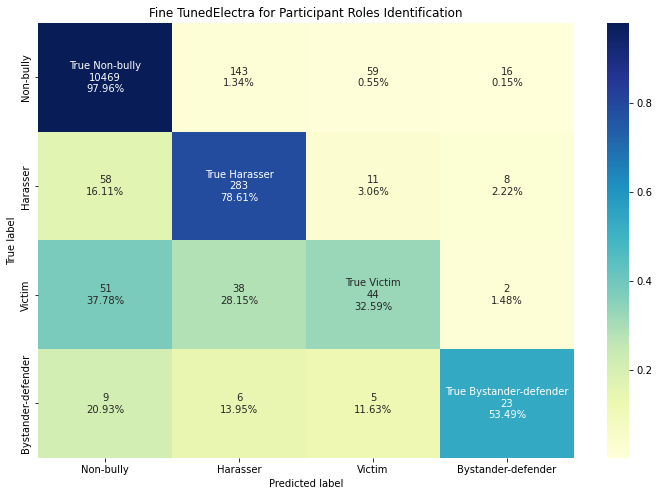

In [13]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-14325', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 4

loading configuration file content/drive/MyDrive/output_Electra/holdout/checkpoint-19100/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive/output_Electra/holdout/checkpoint-19100",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.59      0.79      0.67       360
           2       0.44      0.36      0.40       135
           3       0.39      0.60      0.47        43

    accuracy                           0.96     11225
   macro avg       0.60      0.68      0.63     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.600994988210831
Recall:  0.6835816346375252
F-measure:  0.6318889648941323

Label 0: Non-bully
Precision:  0.9892086330935251
Recall:  0.9778235239075512
F-measure:  0.9834831302056375

Label 1: Harasser
Precision:  0.5892116182572614
Recall:  0.7888888888888889
F-measure:  0.6745843230403801

Label 2: Victim
Precision:  0.4375
Recall:  0.362962962962963
F-measure:  0.3967611336032389

Label 3: Bystander-defender
Precision:  0.3880597014925373
Recall:  0.6046511627906976
F-measure:  0.4727272727272727



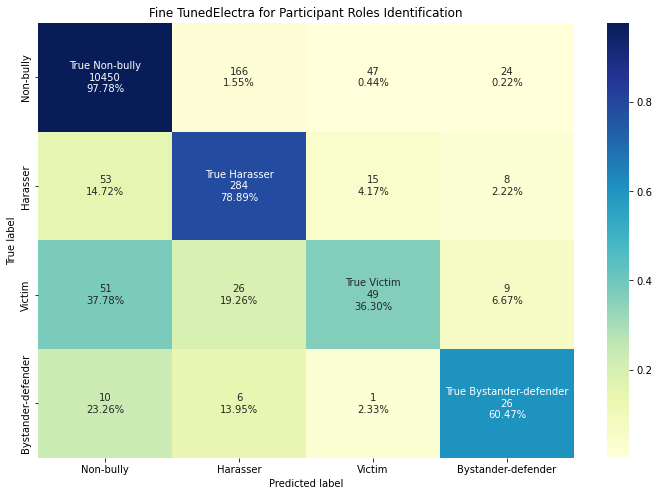

In [14]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-19100', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 5

loading configuration file content/drive/MyDrive/output_Electra/holdout/checkpoint-23875/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive/output_Electra/holdout/checkpoint-23875",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.62      0.75      0.68       360
           2       0.35      0.47      0.41       135
           3       0.42      0.58      0.49        43

    accuracy                           0.96     11225
   macro avg       0.60      0.70      0.64     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.5958946030714508
Recall:  0.695659486353815
F-measure:  0.6387211262162473

Label 0: Non-bully
Precision:  0.9897640034119989
Recall:  0.9771685225039768
F-measure:  0.9834259346454469

Label 1: Harasser
Precision:  0.6235565819861432
Recall:  0.75
F-measure:  0.6809583858764188

Label 2: Victim
Precision:  0.35359116022099446
Recall:  0.4740740740740741
F-measure:  0.4050632911392405

Label 3: Bystander-defender
Precision:  0.4166666666666667
Recall:  0.5813953488372093
F-measure:  0.4854368932038835



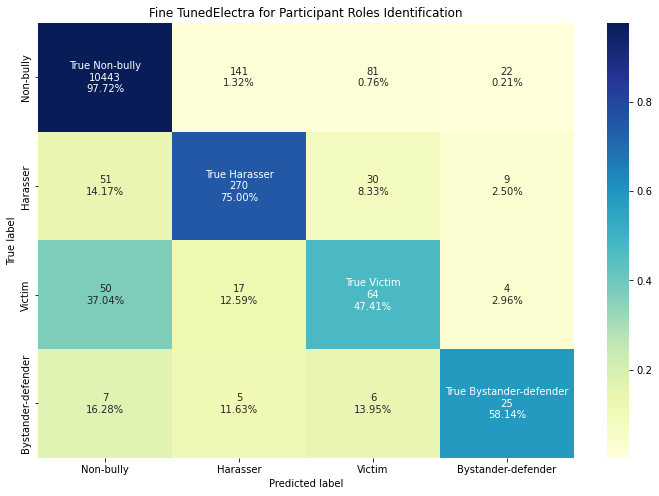

In [15]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-23875', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 6

loading configuration file content/drive/MyDrive/output_Electra/holdout/checkpoint-28650/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive/output_Electra/holdout/checkpoint-28650",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10687
           1       0.59      0.79      0.67       360
           2       0.34      0.48      0.40       135
           3       0.45      0.60      0.51        43

    accuracy                           0.96     11225
   macro avg       0.59      0.71      0.64     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.5925171860180634
Recall:  0.7114641389955372
F-measure:  0.6425628372397921

Label 0: Non-bully
Precision:  0.9913300304878049
Recall:  0.9736128005988585
F-measure:  0.9823915403861588

Label 1: Harasser
Precision:  0.5883575883575883
Recall:  0.7861111111111111
F-measure:  0.6730083234244947

Label 2: Victim
Precision:  0.34210526315789475
Recall:  0.48148148148148145
F-measure:  0.39999999999999997

Label 3: Bystander-defender
Precision:  0.4482758620689655
Recall:  0.6046511627906976
F-measure:  0.51485

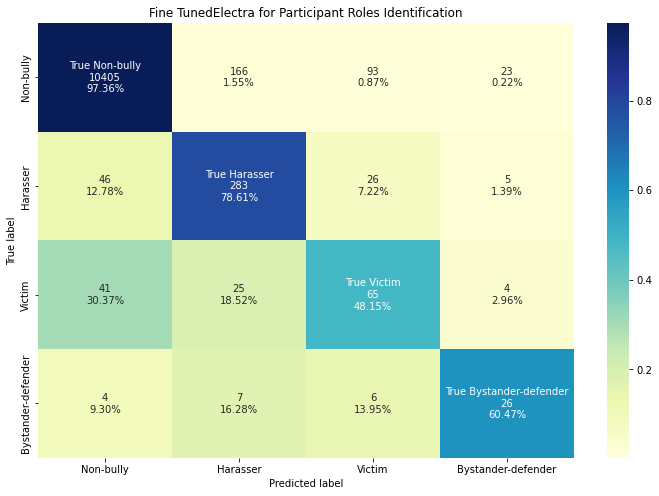

In [16]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-28650', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 7

loading configuration file content/drive/MyDrive/output_Electra/holdout/checkpoint-33425/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive/output_Electra/holdout/checkpoint-33425",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.62      0.78      0.69       360
           2       0.37      0.44      0.40       135
           3       0.48      0.58      0.53        43

    accuracy                           0.96     11225
   macro avg       0.62      0.70      0.65     11225
weighted avg       0.97      0.96      0.97     11225


Macro Metrics:
Precision:  0.6161779102306275
Recall:  0.6955006311853689
F-measure:  0.6516773079525493

Label 0: Non-bully
Precision:  0.9899640219655368
Recall:  0.9783849536820436
F-measure:  0.9841404301378889

Label 1: Harasser
Precision:  0.623608017817372
Recall:  0.7777777777777778
F-measure:  0.6922126081582202

Label 2: Victim
Precision:  0.37037037037037035
Recall:  0.4444444444444444
F-measure:  0.404040404040404

Label 3: Bystander-defender
Precision:  0.4807692307692308
Recall:  0.5813953488372093
F-measure:  0.526315789

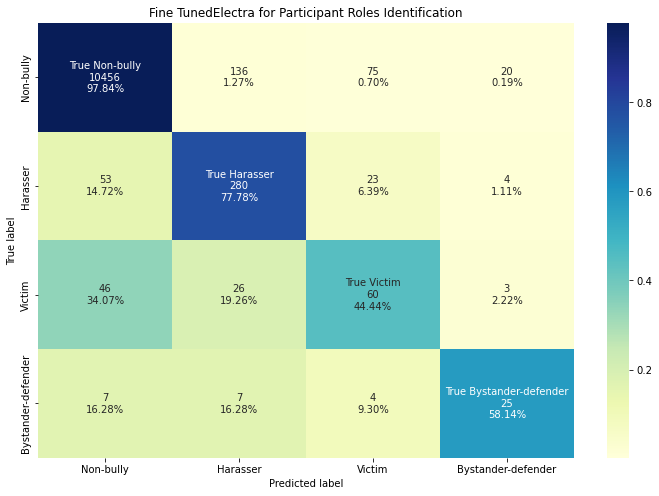

In [19]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-33425', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 8

loading configuration file content/drive/MyDrive/output_Electra/holdout/checkpoint-38200/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive/output_Electra/holdout/checkpoint-38200",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.60      0.79      0.68       360
           2       0.35      0.45      0.40       135
           3       0.43      0.58      0.50        43

    accuracy                           0.96     11225
   macro avg       0.59      0.70      0.64     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.5937209817581538
Recall:  0.7007003979494193
F-measure:  0.6394872392180001

Label 0: Non-bully
Precision:  0.9908719216506608
Recall:  0.9751099466641714
F-measure:  0.98292774948123

Label 1: Harasser
Precision:  0.5983263598326359
Recall:  0.7944444444444444
F-measure:  0.6825775656324582

Label 2: Victim
Precision:  0.3546511627906977
Recall:  0.45185185185185184
F-measure:  0.39739413680781754

Label 3: Bystander-defender
Precision:  0.43103448275862066
Recall:  0.5813953488372093
F-measure:  0.4950495

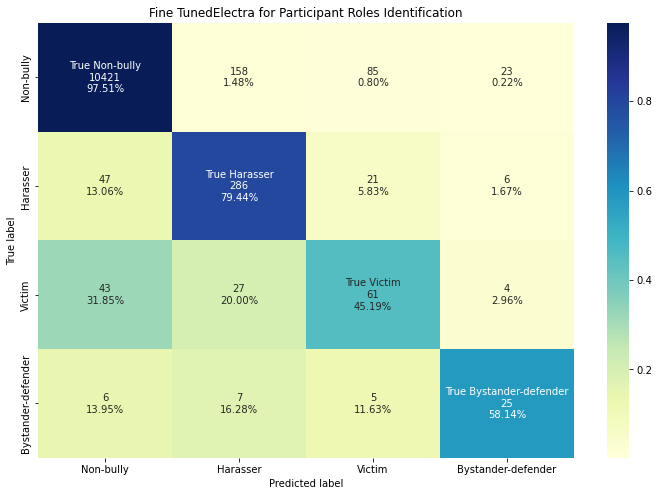

In [20]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-38200', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 9

In [ ]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 10

In [ ]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive/output_Electra/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_test)